# # NYC Taxi Trip Duration Analysis & Clustering
# 
# **Objective:**  
# Analyze NYC taxi trip data to understand trip patterns, segment rides into operational clusters, and prepare insights for a Power BI dashboard.
# 
# **Dataset:**  
# NYC Taxi Trip Duration (Kaggle)
# 
# **Approach:**
# 1. Data cleaning and feature engineering
# 2. Exploratory data analysis (EDA)
# 3. K-Means clustering to identify trip segments
# 4. Export data for Power BI visualization


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid")


# ---
# ## 1. Data Loading & Initial Cleaning


# ### 1.1 Load Data


In [2]:
df = pd.read_csv('train.csv')

print(f"Original shape: {df.shape}")
print("First rows:")
display(df.head())
print("Data types:")
print(df.info())
print("Descriptive statistics:")
display(df.describe())


Original shape: (1458644, 11)
First rows:


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435


Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
Descriptive statistics:


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,"1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00","1,458,644.00"
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,"5,237.43"
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,"1,075.00"
max,2.00,9.00,-61.34,51.88,-61.34,43.92,"3,526,282.00"


# ### 1.2 Initial Cleaning


In [3]:
# Remove rows with null values (if any)
df = df.dropna()

# Convert pickup_datetime and dropoff_datetime to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

print(f"Shape after removing nulls: {df.shape}")


Shape after removing nulls: (1458644, 11)


# ### 1.3 Filter Outliers Using Percentiles


In [4]:
# trip_duration: remove extreme outliers using 0.5% and 99.5% percentiles
lower_percentile = df['trip_duration'].quantile(0.005)
upper_percentile = df['trip_duration'].quantile(0.995)

print(f"0.5% percentile of trip_duration: {lower_percentile:.2f} seconds ({lower_percentile/60:.2f} minutes)")
print(f"  → Rows below: {len(df[df['trip_duration'] <= lower_percentile])} ({len(df[df['trip_duration'] <= lower_percentile])/len(df)*100:.2f}%)")
print(f"99.5% percentile of trip_duration: {upper_percentile:.2f} seconds ({upper_percentile/60:.2f} minutes)")
print(f"  → Rows above: {len(df[df['trip_duration'] >= upper_percentile])} ({len(df[df['trip_duration'] >= upper_percentile])/len(df)*100:.2f}%)")

df = df[(df['trip_duration'] >= lower_percentile) & 
        (df['trip_duration'] <= upper_percentile)]

print(f"Shape after trip_duration filter: {df.shape}")


0.5% percentile of trip_duration: 50.00 seconds (0.83 minutes)
  → Rows below: 7333 (0.50%)
99.5% percentile of trip_duration: 4139.00 seconds (68.98 minutes)
  → Rows above: 7298 (0.50%)
Shape after trip_duration filter: (1444166, 11)


In [5]:
# passenger_count: keep only reasonable values (1 to 6)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

print(f"Shape after passenger_count filter: {df.shape}")


Shape after passenger_count filter: (1444147, 11)


In [6]:
# Coordinates: filter to approximate NYC bounding box
# NYC approximately: Latitude 40.5–41.0, Longitude -74.3 to -73.7

df = df[
    (df['pickup_latitude'] >= 40.5) & (df['pickup_latitude'] <= 41.0) &
    (df['pickup_longitude'] >= -74.3) & (df['pickup_longitude'] <= -73.7) &
    (df['dropoff_latitude'] >= 40.5) & (df['dropoff_latitude'] <= 41.0) &
    (df['dropoff_longitude'] >= -74.3) & (df['dropoff_longitude'] <= -73.7)
]

print(f"Shape after coordinates filter: {df.shape}")


Shape after coordinates filter: (1443365, 11)


# ---
# ## 2. Feature Engineering


# ### 2.1 Temporal Features


In [7]:
# trip_duration in minutes
df['trip_duration_minutes'] = df['trip_duration'] / 60

# Extract temporal features from pickup_datetime
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = (df['pickup_dayofweek'] >= 5).astype(int)  # 1 if Saturday or Sunday

print("Temporal features created:")
print(df[['pickup_datetime', 'pickup_hour', 'pickup_dayofweek', 'is_weekend']].head())


Temporal features created:
      pickup_datetime  pickup_hour  pickup_dayofweek  is_weekend
0 2016-03-14 17:24:55           17                 0           0
1 2016-06-12 00:43:35            0                 6           1
2 2016-01-19 11:35:24           11                 1           0
3 2016-04-06 19:32:31           19                 2           0
4 2016-03-26 13:30:55           13                 5           1


# ### 2.2 Distance Calculation (Haversine Formula)


In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """    Calculate the distance in km between two points on Earth using the Haversine formula.
    This is a straight-line distance over the Earth's surface, not the actual driving route.
    """
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    # Earth radius in km
    r = 6371

    return c * r


df['distance_km'] = df.apply(
    lambda row: haversine(
        row['pickup_longitude'], row['pickup_latitude'],
        row['dropoff_longitude'], row['dropoff_latitude']
    ), axis=1
)

print("Distance feature created.")


Distance feature created.


# ### 2.3 Speed Calculation & Filtering


In [9]:
# Calculate average speed (km/h)
df['speed_kmh'] = df['distance_km'] / (df['trip_duration'] / 3600)

# Remove rows where speed is zero or unreasonably high (> 100 km/h in NYC)
df = df[(df['speed_kmh'] > 0) & (df['speed_kmh'] <= 100)]

print(f"Shape after speed filter: {df.shape}")


Shape after speed filter: (1439112, 19)


# ### 2.4 Final Verification


In [10]:
print("=== FINAL SUMMARY ===")
print(f"Final shape: {df.shape}")
print("First rows with new features:")
display(df[['trip_duration_minutes', 'pickup_hour', 'pickup_dayofweek', 
            'is_weekend', 'distance_km', 'speed_kmh']].head(10))

print("Descriptive statistics of new features:")
display(df[['trip_duration_minutes', 'distance_km', 'speed_kmh']].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))


=== FINAL SUMMARY ===
Final shape: (1439112, 19)
First rows with new features:


,trip_duration_minutes,pickup_hour,pickup_dayofweek,is_weekend,distance_km,speed_kmh
0,7.58,17,0,0,1.50,11.86
1,11.05,0,6,1,1.81,9.80
2,35.40,11,1,0,6.39,10.82
3,7.15,19,2,0,1.49,12.47
4,7.25,13,5,1,1.19,9.84
5,7.38,22,5,1,1.10,8.93
6,5.68,22,4,0,1.33,14.00
7,25.85,7,5,1,5.71,13.26
8,4.25,23,4,0,1.31,18.50
9,20.42,21,3,0,5.12,15.05


Descriptive statistics of new features:


,trip_duration_minutes,distance_km,speed_kmh
count,"1,439,112.00","1,439,112.00","1,439,112.00"
mean,13.77,3.40,14.44
std,10.14,3.78,7.64
min,0.83,0.00,0.00
5%,3.12,0.63,5.28
25%,6.67,1.25,9.20
50%,11.05,2.10,12.83
75%,17.82,3.86,17.88
95%,34.00,10.67,29.37
max,68.98,47.77,99.53


# ---
# ## 3. Exploratory Data Analysis (EDA)


# ### 3.1 Descriptive Statistics


In [11]:
print("=== Descriptive statistics: trip_duration_minutes ===")
display(df['trip_duration_minutes'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

print("=== Descriptive statistics: distance_km ===")
display(df['distance_km'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

print("=== Descriptive statistics: speed_kmh ===")
display(df['speed_kmh'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))


=== Descriptive statistics: trip_duration_minutes ===


count   1,439,112.00
mean           13.77
std            10.14
min             0.83
5%              3.12
25%             6.67
50%            11.05
75%            17.82
95%            34.00
max            68.98
Name: trip_duration_minutes, dtype: float64

=== Descriptive statistics: distance_km ===


count   1,439,112.00
mean            3.40
std             3.78
min             0.00
5%              0.63
25%             1.25
50%             2.10
75%             3.86
95%            10.67
max            47.77
Name: distance_km, dtype: float64

=== Descriptive statistics: speed_kmh ===


count   1,439,112.00
mean           14.44
std             7.64
min             0.00
5%              5.28
25%             9.20
50%            12.83
75%            17.88
95%            29.37
max            99.53
Name: speed_kmh, dtype: float64

# ### 3.2 Distributions


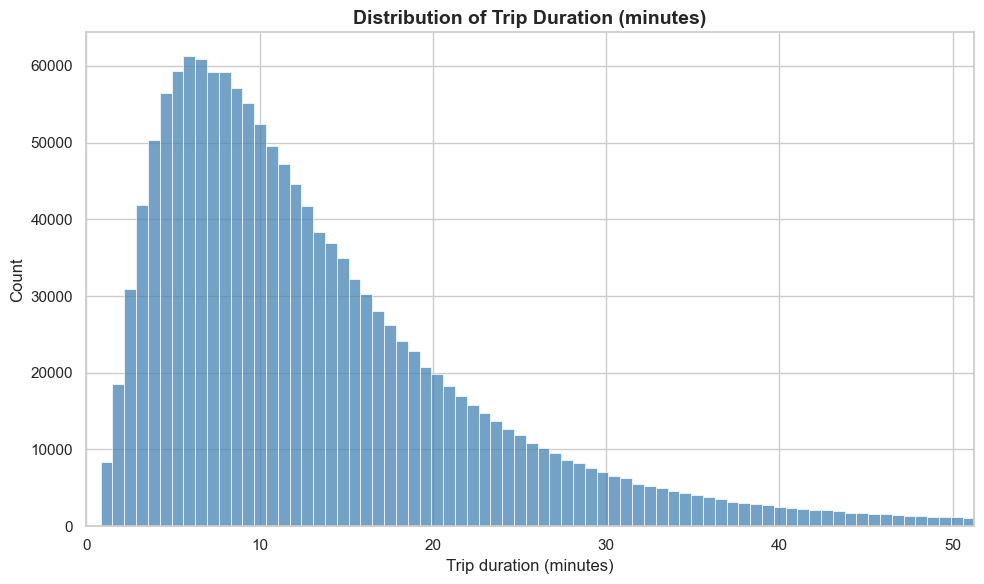

In [12]:
# Trip duration (in minutes) - histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_duration_minutes'], bins=100, kde=False, color='steelblue')
plt.title('Distribution of Trip Duration (minutes)', fontsize=14, fontweight='bold')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Count')
plt.xlim(0, df['trip_duration_minutes'].quantile(0.99))
plt.tight_layout()
plt.show()


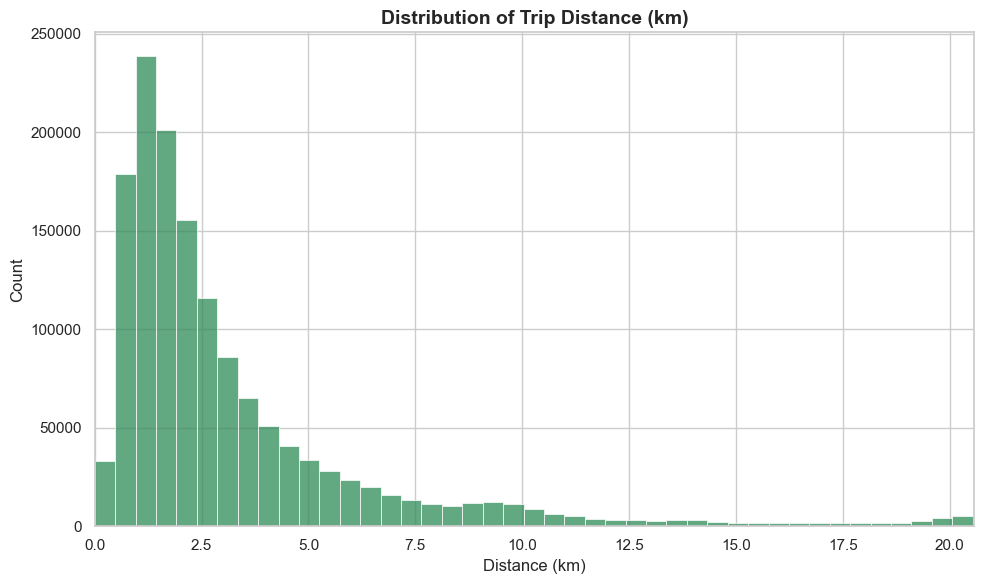

In [13]:
# Distance (in km) - histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['distance_km'], bins=100, kde=False, color='seagreen')
plt.title('Distribution of Trip Distance (km)', fontsize=14, fontweight='bold')
plt.xlabel('Distance (km)')
plt.ylabel('Count')
plt.xlim(0, df['distance_km'].quantile(0.99))
plt.tight_layout()
plt.show()


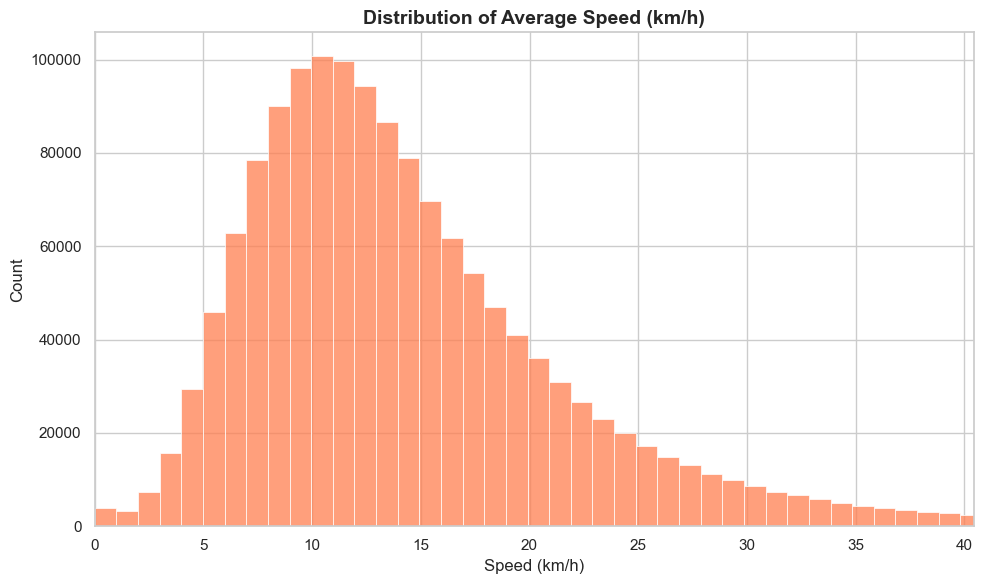

In [14]:
# Speed (km/h) - histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['speed_kmh'], bins=100, kde=False, color='coral')
plt.title('Distribution of Average Speed (km/h)', fontsize=14, fontweight='bold')
plt.xlabel('Speed (km/h)')
plt.ylabel('Count')
plt.xlim(0, df['speed_kmh'].quantile(0.99))
plt.tight_layout()
plt.show()


# ### 3.3 Relationship Between Distance and Duration


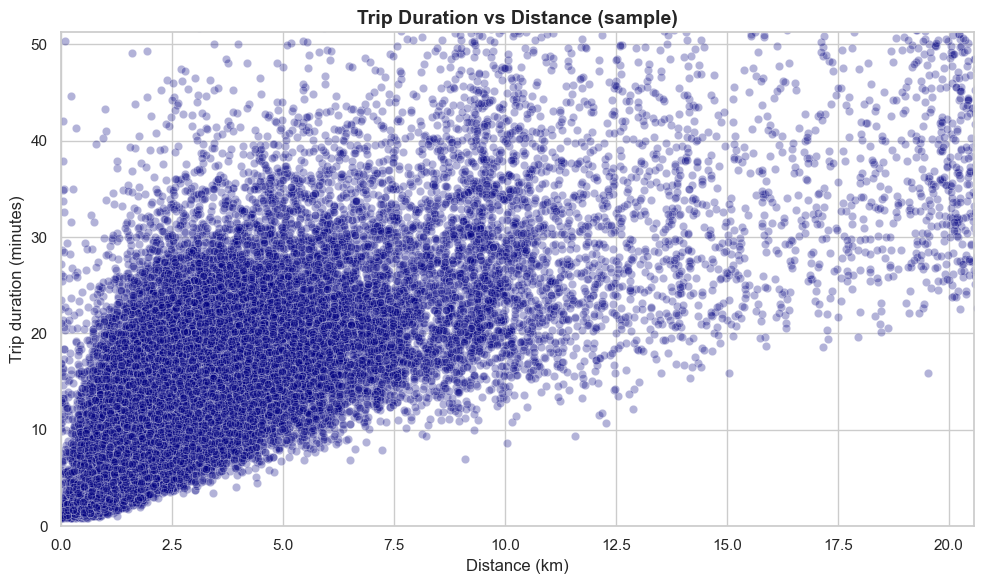

In [15]:
# Sample for visualization to reduce overplotting
df_sample = df.sample(n=50000, random_state=42) if len(df) > 50000 else df.copy()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample,
    x='distance_km',
    y='trip_duration_minutes',
    alpha=0.3,
    color='navy'
)
plt.title('Trip Duration vs Distance (sample)', fontsize=14, fontweight='bold')
plt.xlabel('Distance (km)')
plt.ylabel('Trip duration (minutes)')
plt.xlim(0, df['distance_km'].quantile(0.99))
plt.ylim(0, df['trip_duration_minutes'].quantile(0.99))
plt.tight_layout()
plt.show()


In [16]:
# Average duration by distance bins
df['distance_bin_km'] = pd.cut(
    df['distance_km'],
    bins=[0, 1, 2, 5, 10, 20, 50],
    include_lowest=True
)

duration_by_distance_bin = df.groupby('distance_bin_km', observed=True)['trip_duration_minutes'].agg(['count', 'mean', 'median']).reset_index()
print("=== Trip duration by distance bin (km) ===")
display(duration_by_distance_bin)


=== Trip duration by distance bin (km) ===


,distance_bin_km,count,mean,median
0,"(-0.001, 1.0]",234035,5.50,4.53
1,"(1.0, 2.0]",450558,8.92,7.93
2,"(2.0, 5.0]",497955,14.81,13.57
3,"(5.0, 10.0]",172791,23.76,22.12
4,"(10.0, 20.0]",63303,33.57,31.50
5,"(20.0, 50.0]",20470,44.04,43.02


# ### 3.4 Patterns by Hour of Day


In [17]:
# Average duration and count by pickup_hour
hourly_stats = df.groupby('pickup_hour').agg(
    avg_duration=('trip_duration_minutes', 'mean'),
    median_duration=('trip_duration_minutes', 'median'),
    trip_count=('trip_duration_minutes', 'count')
).reset_index()

print("=== Hourly stats (by pickup_hour) ===")
display(hourly_stats)


=== Hourly stats (by pickup_hour) ===


,pickup_hour,avg_duration,median_duration,trip_count
0,0,13.02,10.78,52615
1,1,12.24,10.23,38048
2,2,11.74,9.88,27623
3,3,11.76,9.92,20596
4,4,12.34,10.27,15508
5,5,11.92,8.73,14753
6,6,10.97,7.90,32742
7,7,12.07,9.55,54622
8,8,13.66,11.00,66173
9,9,13.99,11.35,66991


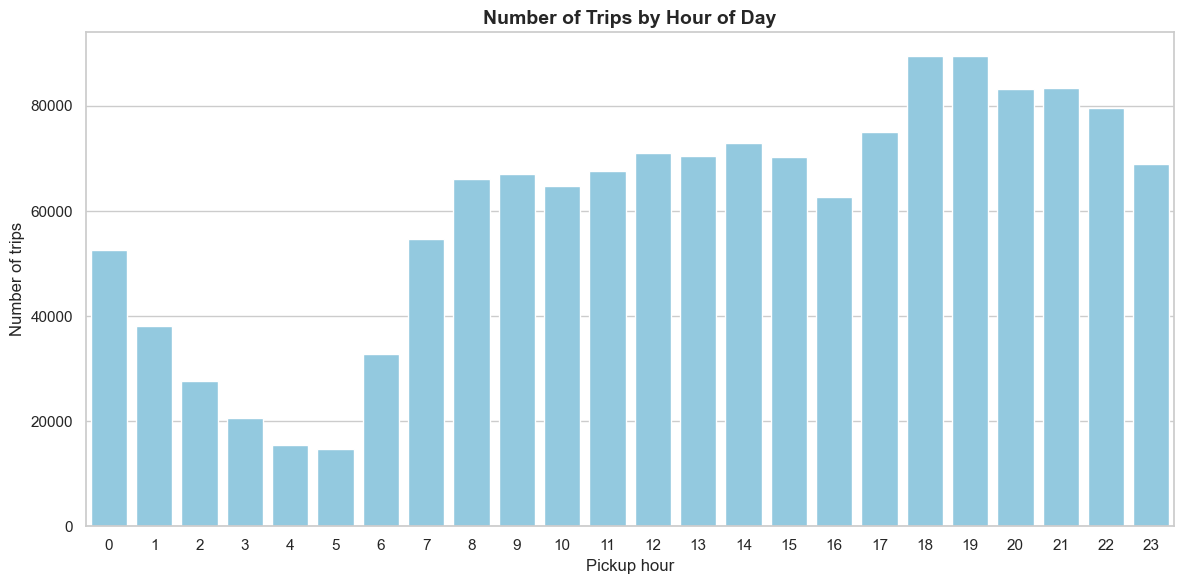

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_stats, x='pickup_hour', y='trip_count', color='skyblue')
plt.title('Number of Trips by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Pickup hour')
plt.ylabel('Number of trips')
plt.tight_layout()
plt.show()


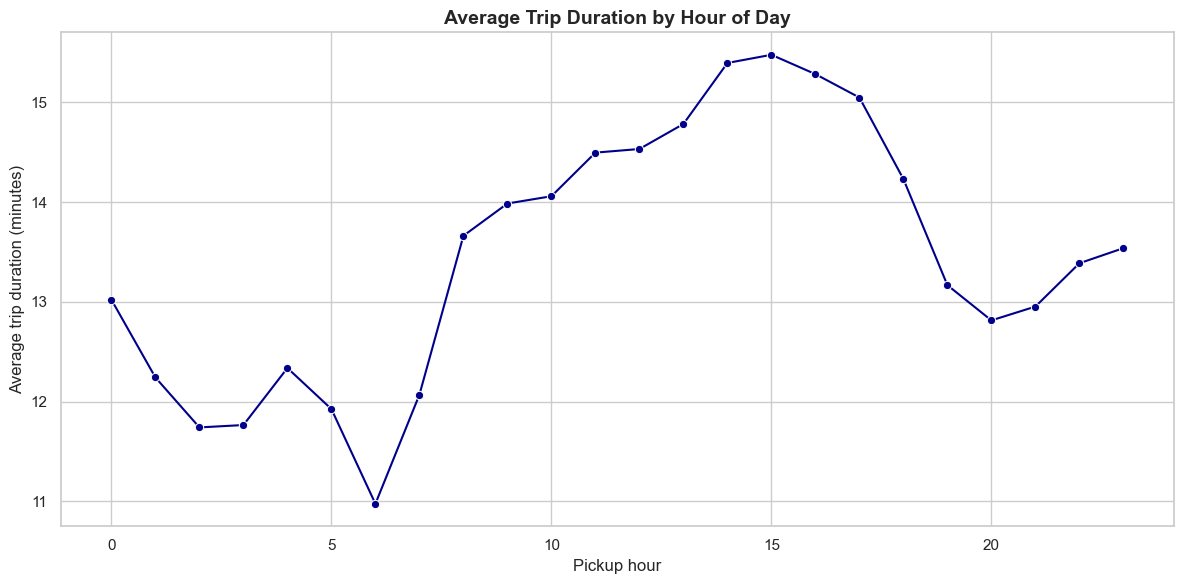

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_stats, x='pickup_hour', y='avg_duration', marker='o', color='darkblue')
plt.title('Average Trip Duration by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Pickup hour')
plt.ylabel('Average trip duration (minutes)')
plt.tight_layout()
plt.show()


# ### 3.5 Patterns by Day of Week


In [20]:
# Average duration and count by day of week (0=Monday, 6=Sunday)
dow_stats = df.groupby('pickup_dayofweek').agg(
    avg_duration=('trip_duration_minutes', 'mean'),
    median_duration=('trip_duration_minutes', 'median'),
    trip_count=('trip_duration_minutes', 'count')
).reset_index()

print("=== Stats by day of week (0=Mon, 6=Sun) ===")
display(dow_stats)


=== Stats by day of week (0=Mon, 6=Sun) ===


,pickup_dayofweek,avg_duration,median_duration,trip_count
0,0,13.30,10.50,184930
1,1,14.08,11.32,200110
2,2,14.40,11.55,207248
3,3,14.68,11.82,215233
4,4,14.17,11.42,220197
5,5,12.95,10.63,218465
6,6,12.65,10.07,192929


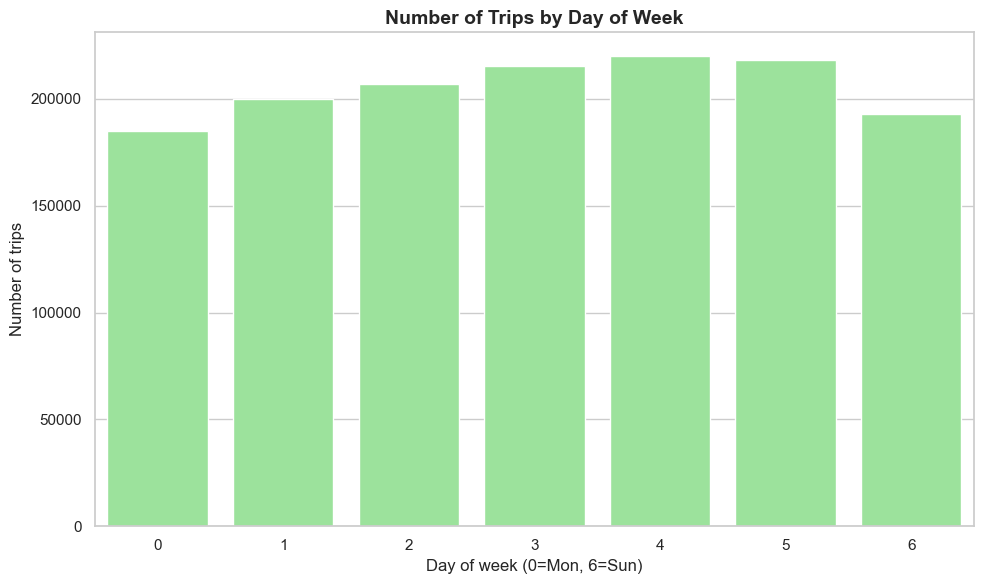

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=dow_stats, x='pickup_dayofweek', y='trip_count', color='lightgreen')
plt.title('Number of Trips by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of week (0=Mon, 6=Sun)')
plt.ylabel('Number of trips')
plt.tight_layout()
plt.show()


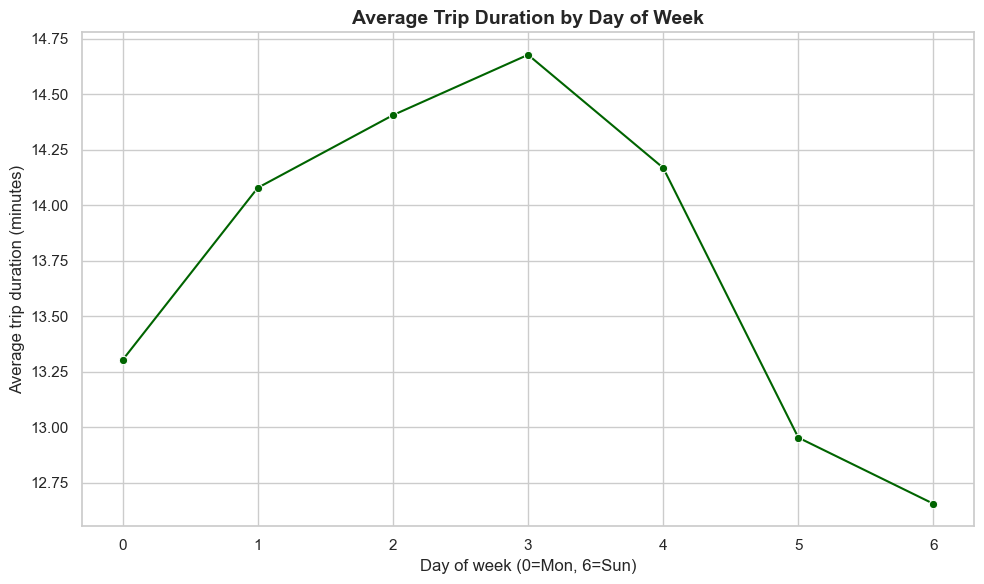

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=dow_stats, x='pickup_dayofweek', y='avg_duration', marker='o', color='darkgreen')
plt.title('Average Trip Duration by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of week (0=Mon, 6=Sun)')
plt.ylabel('Average trip duration (minutes)')
plt.tight_layout()
plt.show()


# ### 3.6 Weekend vs Weekday Comparison


In [23]:
weekend_stats = df.groupby('is_weekend').agg(
    avg_duration=('trip_duration_minutes', 'mean'),
    median_duration=('trip_duration_minutes', 'median'),
    trip_count=('trip_duration_minutes', 'count'),
    avg_distance=('distance_km', 'mean')
).reset_index()

weekend_stats['is_weekend'] = weekend_stats['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

print("=== Weekend vs Weekday stats ===")
display(weekend_stats)


=== Weekend vs Weekday stats ===


,is_weekend,avg_duration,median_duration,trip_count,avg_distance
0,Weekday,14.15,11.33,1027718,3.35
1,Weekend,12.81,10.35,411394,3.51


# ---
# ## 4. Feature Preparation for Clustering


# ### 4.1 Cap Extreme Values
# 
# We cap features at the 99th percentile to prevent a few extreme outliers from dominating the clustering algorithm.


In [24]:
# Cap trip_duration_minutes at 99th percentile
duration_cap = df['trip_duration_minutes'].quantile(0.99)
df['trip_duration_capped'] = df['trip_duration_minutes'].clip(upper=duration_cap)

# Cap distance_km at 99th percentile
distance_cap = df['distance_km'].quantile(0.99)
df['distance_km_capped'] = df['distance_km'].clip(upper=distance_cap)

# Cap speed_kmh at 99th percentile
speed_cap = df['speed_kmh'].quantile(0.99)
df['speed_kmh_capped'] = df['speed_kmh'].clip(upper=speed_cap)

print("Capping thresholds:")
print(f"  99th percentile of trip_duration_minutes: {duration_cap:.2f}")
print(f"  99th percentile of distance_km: {distance_cap:.2f}")
print(f"  99th percentile of speed_kmh: {speed_cap:.2f}")


Capping thresholds:
  99th percentile of trip_duration_minutes: 51.23
  99th percentile of distance_km: 20.57
  99th percentile of speed_kmh: 40.43


# ### 4.2 Select Features for Clustering


In [25]:
features_for_clustering = [
    'trip_duration_capped',
    'distance_km_capped',
    'speed_kmh_capped',
    'pickup_hour',
    'is_weekend'
]

df_cluster = df[features_for_clustering].copy()

print("Sample of features for clustering:")
display(df_cluster.head())

print("Descriptive statistics of clustering features:")
display(df_cluster.describe())


Sample of features for clustering:


,trip_duration_capped,distance_km_capped,speed_kmh_capped,pickup_hour,is_weekend
0,7.58,1.50,11.86,17,0
1,11.05,1.81,9.80,0,1
2,35.40,6.39,10.82,11,0
3,7.15,1.49,12.47,19,0
4,7.25,1.19,9.84,13,1


Descriptive statistics of clustering features:


,trip_duration_capped,distance_km_capped,speed_kmh_capped,pickup_hour,is_weekend
count,"1,439,112.00","1,439,112.00","1,439,112.00","1,439,112.00","1,439,112.00"
mean,13.70,3.38,14.39,13.61,0.29
std,9.84,3.71,7.42,6.40,0.45
min,0.83,0.00,0.00,0.00,0.00
25%,6.67,1.25,9.20,9.00,0.00
50%,11.05,2.10,12.83,14.00,0.00
75%,17.82,3.86,17.88,19.00,1.00
max,51.23,20.57,40.43,23.00,1.00


# ---
# ## 5. K-Means Clustering


# ### 5.1 Standardize Features
# 
# K-Means is sensitive to scale. We standardize all features so that variables with larger ranges (e.g., distance_km) don't dominate over binary variables (e.g., is_weekend).


In [26]:
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

print("Standardized features (first 5 rows):")
print(df_cluster_scaled[:5])


Standardized features (first 5 rows):
[[-0.62103698 -0.50802862 -0.34150865  0.52926242 -0.63269149]
 [-0.26890086 -0.42529485 -0.61830534 -2.12563011  1.58054915]
 [ 2.20451681  0.80891907 -0.4809645  -0.40775847 -0.63269149]
 [-0.665054   -0.51153819 -0.25935122  0.84160271 -0.63269149]
 [-0.65489622 -0.59155633 -0.61386432 -0.09541818  1.58054915]]


# ### 5.2 Determine Optimal Number of Clusters (k)
# 
# We'll test k = 3, 4, 5 using a sample of 200k rows to speed up computation.  
# We'll evaluate using:
# - **Elbow Method** (Inertia)
# - **Silhouette Score**


In [27]:
# Sample for k selection
sample_size = 200_000

if len(df_cluster) > sample_size:
    df_cluster_sample = df_cluster.sample(n=sample_size, random_state=42)
else:
    df_cluster_sample = df_cluster.copy()

scaler_sample = StandardScaler()
df_cluster_sample_scaled = scaler_sample.fit_transform(df_cluster_sample)

print(f"Sample shape for k selection: {df_cluster_sample.shape}")


Sample shape for k selection: (200000, 5)


In [28]:
k_values = [3, 4, 5]
inertias = []
silhouette_scores_list = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(df_cluster_sample_scaled)

    inertia = kmeans.inertia_
    sil_score = silhouette_score(df_cluster_sample_scaled, kmeans.labels_)

    inertias.append(inertia)
    silhouette_scores_list.append(sil_score)

    print(f"k = {k}")
    print(f"  Inertia: {inertia:,.2f}")
    print(f"  Silhouette score: {sil_score:.4f}")


k = 3
  Inertia: 553,156.44
  Silhouette score: 0.3491
k = 4
  Inertia: 471,789.36
  Silhouette score: 0.2744
k = 5
  Inertia: 415,861.57
  Silhouette score: 0.2741


# ### 5.3 Visualize Elbow and Silhouette Scores


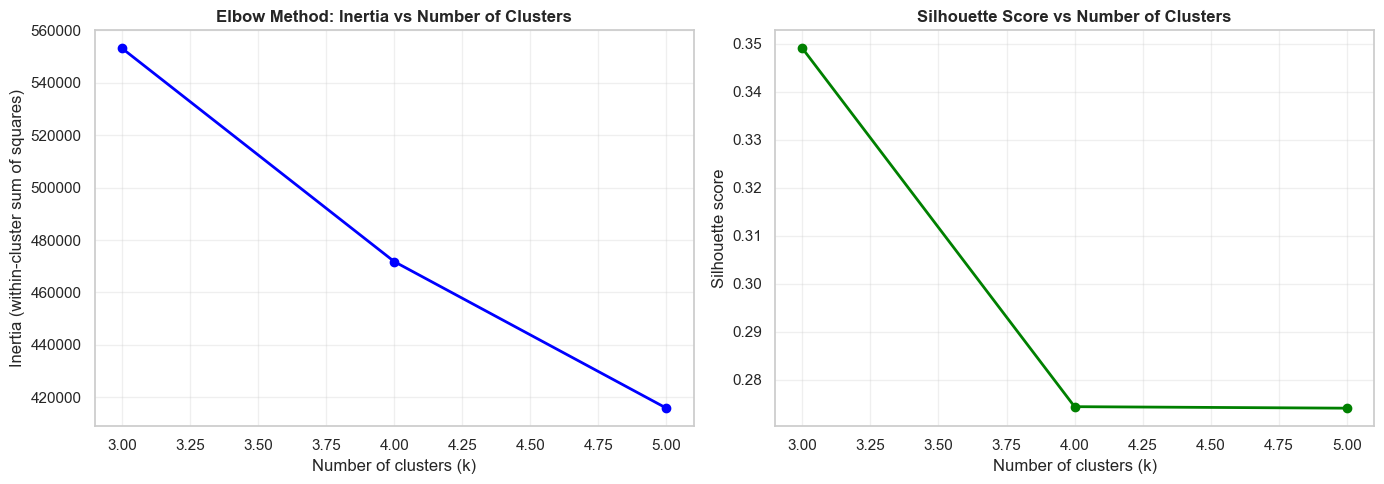

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_values, inertias, marker='o', linestyle='-', color='blue', linewidth=2)
axes[0].set_title('Elbow Method: Inertia vs Number of Clusters', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Inertia (within-cluster sum of squares)')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_values, silhouette_scores_list, marker='o', linestyle='-', color='green', linewidth=2)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Silhouette score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ### 5.4 Fit Final K-Means Model on Full Dataset
# 
# Based on the Elbow and Silhouette analysis, we select **k = 4** as the optimal number of clusters.


In [30]:
# Fit scaler on full data
scaler_full = StandardScaler()
df_cluster_scaled_full = scaler_full.fit_transform(df_cluster)

optimal_k = 4  # Adjust based on your analysis

print(f"=== Fitting final K-Means model with k = {optimal_k} on full dataset ===")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=5)
df['cluster'] = kmeans_final.fit_predict(df_cluster_scaled_full)

print("Cluster labels assigned to full dataframe.")
print("Cluster distribution:")
display(df['cluster'].value_counts().sort_index())


=== Fitting final K-Means model with k = 4 on full dataset ===
Cluster labels assigned to full dataframe.
Cluster distribution:


cluster
0    410933
1    147037
2    506658
3    374484
Name: count, dtype: int64

# ---
# ## 6. Cluster Interpretation


# ### 6.1 Cluster Summary Statistics


In [31]:
# Group by cluster and calculate summary stats
cluster_summary = df.groupby('cluster').agg({
    'trip_duration_minutes': ['mean', 'median'],
    'distance_km': ['mean', 'median'],
    'speed_kmh': ['mean', 'median'],
    'pickup_hour': 'mean',
    'is_weekend': 'mean',
    'id': 'count'
}).reset_index()

# Rename columns
cluster_summary.columns = [
    'cluster',
    'avg_duration_min', 'median_duration_min',
    'avg_distance_km', 'median_distance_km',
    'avg_speed_kmh', 'median_speed_kmh',
    'avg_pickup_hour',
    'pct_weekend',
    'trip_count'
]

print("=== Cluster Summary ===")
display(cluster_summary)


=== Cluster Summary ===


,cluster,avg_duration_min,median_duration_min,avg_distance_km,median_distance_km,avg_speed_kmh,median_speed_kmh,avg_pickup_hour,pct_weekend,trip_count
0,0,11.81,10.17,2.24,1.79,12.73,11.31,8.30,0.00,410933
1,1,33.10,31.27,12.58,10.57,24.82,23.51,13.31,0.25,147037
2,2,11.81,10.35,2.31,1.89,12.66,11.78,18.65,0.00,506658
3,3,10.96,9.55,2.52,2.03,14.67,13.63,12.73,1.00,374484


# ### 6.2 Assign Cluster Names
# 
# Based on the summary statistics, we assign meaningful names to each cluster:
# 
# - **Cluster 0**: Weekday morning short trips
# - **Cluster 1**: Long-distance trips (likely airport/inter-borough)
# - **Cluster 2**: Weekday evening short trips
# - **Cluster 3**: Weekend leisure short trips


In [32]:
cluster_labels = {
    0: 'Weekday morning short trips',
    1: 'Long-distance trips',
    2: 'Weekday evening short trips',
    3: 'Weekend leisure short trips'
}


df['cluster_name'] = df['cluster'].map(cluster_labels)

print("Cluster name distribution:")
display(df['cluster_name'].value_counts())


Cluster name distribution:


cluster_name
Weekday evening short trips    506658
Weekday morning short trips    410933
Weekend leisure short trips    374484
Long-distance trips            147037
Name: count, dtype: int64

# ### 6.3 Visualize Clusters


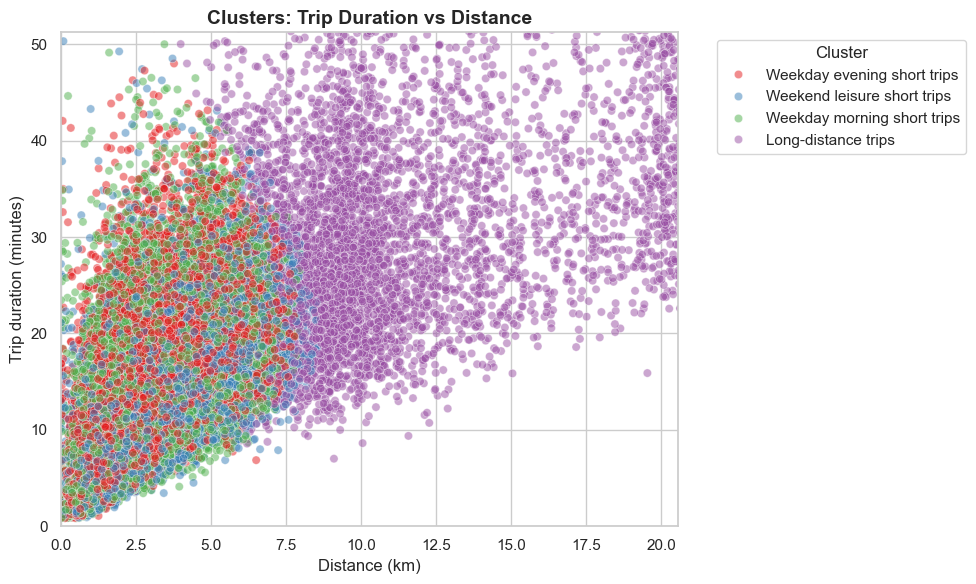

In [33]:
# Sample for visualization
df_sample_viz = df.sample(n=50000, random_state=42) if len(df) > 50000 else df.copy()

# Scatter: distance vs duration, colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample_viz,
    x='distance_km',
    y='trip_duration_minutes',
    hue='cluster_name',
    palette='Set1',
    alpha=0.5
)
plt.title('Clusters: Trip Duration vs Distance', fontsize=14, fontweight='bold')
plt.xlabel('Distance (km)')
plt.ylabel('Trip duration (minutes)')
plt.xlim(0, df['distance_km'].quantile(0.99))
plt.ylim(0, df['trip_duration_minutes'].quantile(0.99))
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\Samuel\AppData\Local\Temp\ipykernel_2340\2258532699.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_name', y='trip_duration_minutes', palette='Set2')


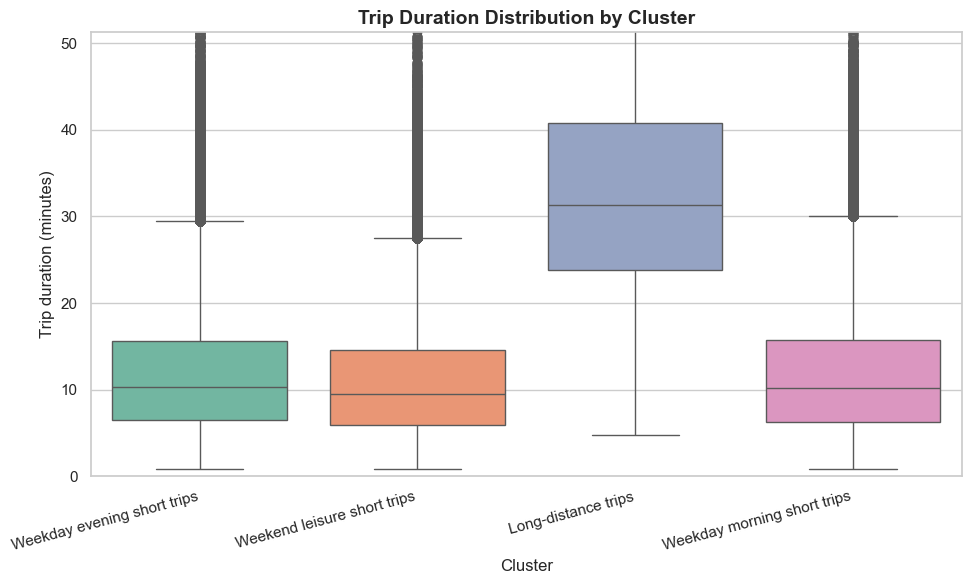

In [34]:
# Boxplot: duration by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster_name', y='trip_duration_minutes', palette='Set2')
plt.title('Trip Duration Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Trip duration (minutes)')
plt.ylim(0, df['trip_duration_minutes'].quantile(0.99))
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


C:\Users\Samuel\AppData\Local\Temp\ipykernel_2340\2649276902.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_name', y='distance_km', palette='Set2')


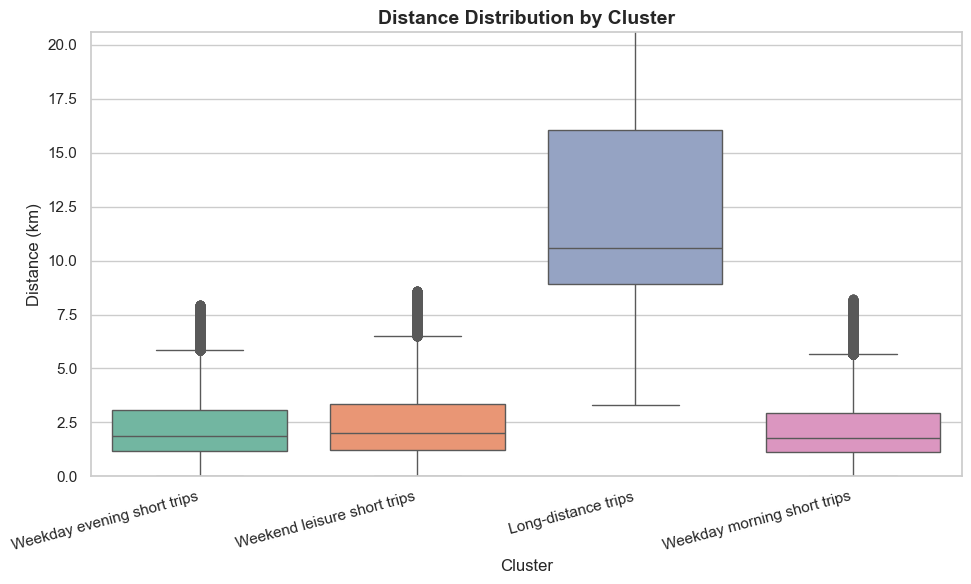

In [35]:
# Boxplot: distance by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cluster_name', y='distance_km', palette='Set2')
plt.title('Distance Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Distance (km)')
plt.ylim(0, df['distance_km'].quantile(0.99))
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


C:\Users\Samuel\AppData\Local\Temp\ipykernel_2340\2772865983.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_hour, x='cluster_name', y='pickup_hour', palette='viridis')


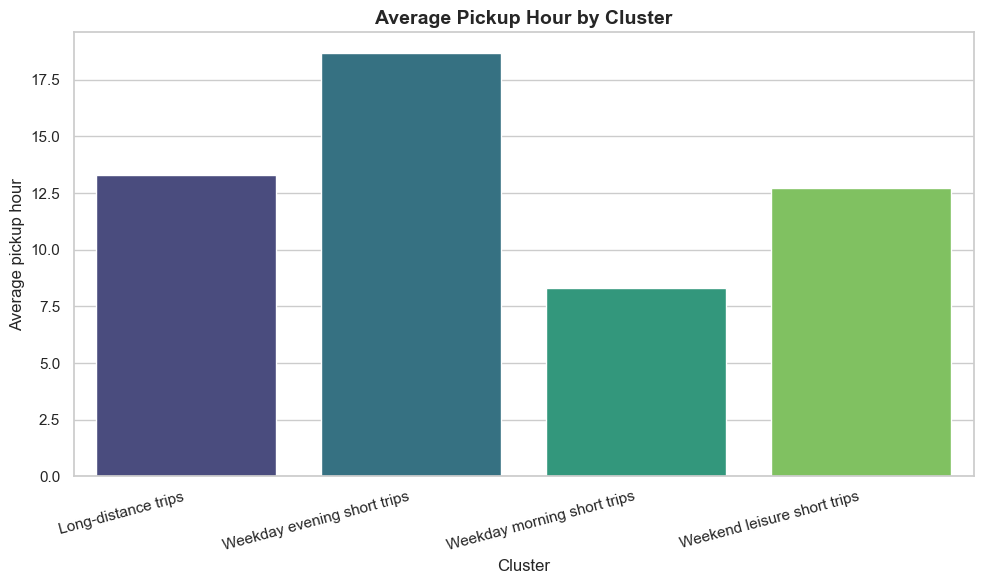

In [36]:
# Bar chart: average pickup hour by cluster
cluster_hour = df.groupby('cluster_name')['pickup_hour'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_hour, x='cluster_name', y='pickup_hour', palette='viridis')
plt.title('Average Pickup Hour by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Average pickup hour')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


# ---
# ## 7. Export Data for Power BI


In [37]:
# Select relevant columns for Power BI
columns_for_bi = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'trip_duration_minutes',
    'distance_km',
    'speed_kmh',
    'pickup_hour',
    'pickup_dayofweek',
    'is_weekend',
    'cluster',
    'cluster_name'
]

# Keep only the columns that actually exist in df
columns_for_bi = [col for col in columns_for_bi if col in df.columns]

df_bi = df[columns_for_bi].copy()

# Save for Power BI
#df_bi.to_csv('nyc_taxi_for_powerbi.csv', index=False)
#cluster_summary.to_csv('nyc_taxi_cluster_summary.csv', index=False)

print("Exports completed:")
print("  - Detailed trips with clusters: 'nyc_taxi_for_powerbi.csv'")
print("  - Cluster summary: 'nyc_taxi_cluster_summary.csv'")


Exports completed:
  - Detailed trips with clusters: 'nyc_taxi_for_powerbi.csv'
  - Cluster summary: 'nyc_taxi_cluster_summary.csv'


# ---
# ## 8. Key Insights & Conclusions
# 
# ### Cluster Profiles:
# 
# **Cluster 0 – Weekday morning short trips**
# - Average duration: ~12 minutes, distance: ~2.2 km
# - Primarily weekday mornings (~8:30 AM)
# - Likely commuter trips (work, school, errands)
# 
# **Cluster 1 – Long-distance trips**
# - Average duration: ~33 minutes, distance: ~12.6 km
# - Higher average speed (~24.8 km/h), suggesting highway/bridge usage
# - Mixed weekday/weekend (~25% weekend)
# - Likely airport or inter-borough trips
# 
# **Cluster 2 – Weekday evening short trips**
# - Average duration: ~12 minutes, distance: ~2.3 km
# - Primarily weekday evenings (~6:30 PM)
# - Likely return commutes or evening social activities
# 
# **Cluster 3 – Weekend leisure short trips**
# - Average duration: ~11 minutes, distance: ~2.5 km
# - 100% weekend trips, midday pickups (~12:30 PM)
# - Likely leisure, dining, shopping trips
# 
# ### Business Implications:
# - **Pricing strategy**: Long-distance trips (Cluster 1) could support premium pricing due to higher value.
# - **Fleet allocation**: High demand during weekday mornings and evenings (Clusters 0 & 2) suggests need for strategic driver positioning.
# - **Weekend operations**: Cluster 3 represents a distinct leisure segment with different demand patterns.
